In [13]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

SEED = 42

### US Census

Predicting whether a person makes over $50,000 a year

#### Data exploartion

In [20]:
X_train = pd.read_csv("./Census Data/X_train.csv")
Y_train = pd.read_csv("./Census Data/y_train.csv")
X_test = pd.read_csv("./Census Data/X_test.csv")

print(X_train.info())
print(X_train.describe())

print("There is {} samples in the dataset.".format(len(X_train)))

print(Y_train.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16280 entries, 0 to 16279
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             16280 non-null  int64  
 1   education-num   16040 non-null  float64
 2   hours-per-week  16280 non-null  int64  
 3   workclass       15344 non-null  object 
 4   education       16280 non-null  object 
 5   marital-status  16280 non-null  object 
 6   occupation      15099 non-null  object 
 7   relationship    16280 non-null  object 
 8   race            16280 non-null  object 
 9   sex             16280 non-null  object 
 10  native-country  15980 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 1.4+ MB
None
                age  education-num  hours-per-week
count  16280.000000    16040.00000    16280.000000
mean      38.600614       10.09414       40.392936
std       13.695138        2.55840       12.345950
min       17.000000        1.00000 

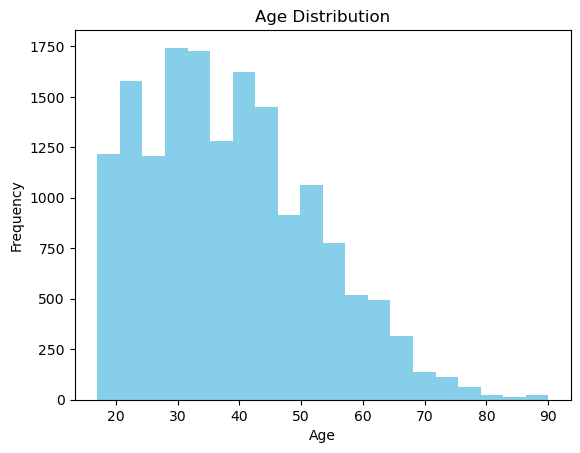

In [9]:
plt.hist(X_train['age'], bins=20, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

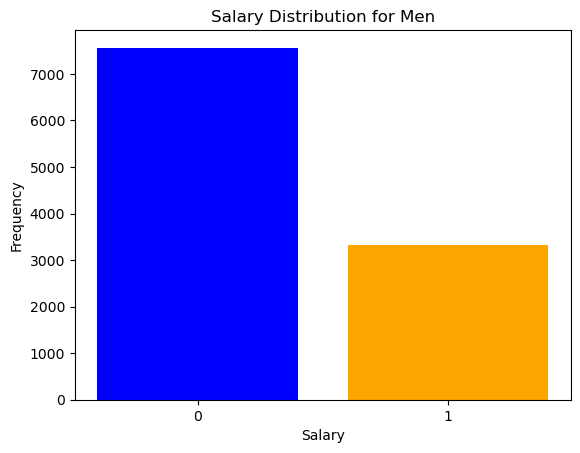

We have data for 10883 men.
7563 (69.49 %) of them earn more than $50,000


In [44]:
# inspecting prevalent biases (gender)

men_salary = Y_train.loc[X_train[X_train['sex'] == ' Male'].index]
women_salary = Y_train.loc[X_train[X_train['sex'] == ' Female'].index]

unique_men, counts_men = np.unique(men_salary, return_counts = True)
frequencies_men = dict(zip(unique_men, counts_men))

unique_women, counts_women = np.unique(women_salary, return_counts = True)
frequencies_women = dict(zip(unique_women, counts_women))

plt.bar(frequencies_men.keys(), frequencies_men.values(), color=['blue', 'orange'])

plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.title('Salary Distribution for Men')
plt.xticks([0, 1], ['0', '1'])
plt.show()

print("We have data for {} men.".format(len(men_salary)))
print("{} ({} %) of them earn more than $50,000".format(frequencies_men[1], round((frequencies_men[1]/len(men_salary)*100), 2)))

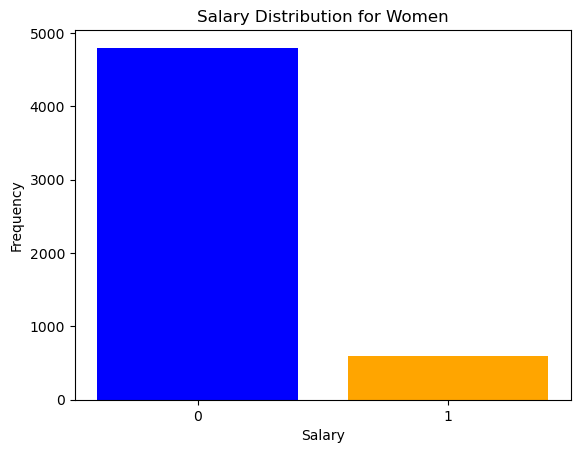

We have data for 5397 women.
600 (5.51 %) of them earn more than $50,000


In [45]:
plt.bar(frequencies_women.keys(), frequencies_women.values(), color=['blue', 'orange'])
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.title('Salary Distribution for Women')
plt.xticks([0, 1], ['0', '1'])
plt.show()

print("We have data for {} women.".format(len(women_salary)))
print("{} ({} %) of them earn more than $50,000".format(frequencies_women[1], round((frequencies_women[1]/len(men_salary)*100), 2)))

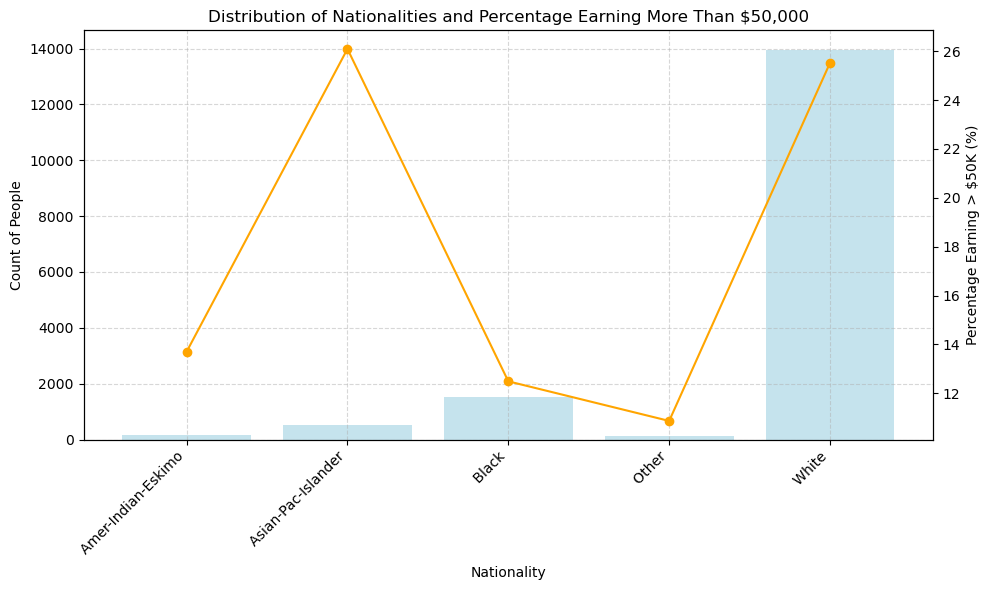

16280


In [65]:
# inspecting prevalent biases (nationality)

nationalities, counts = np.unique(X_train['race'], return_counts = True)
percentages = []
for nationality, count in zip(nationalities, counts):
    salary_above_50 = np.count_nonzero(Y_train.loc[X_train['race'] == nationality])
    percentages.append(round((salary_above_50/count)*100, 2))
    
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the count of people in each nationality
ax1.bar(nationalities, counts, color='lightblue', label='Count', alpha=0.7)
ax1.set_xlabel('Nationality')
ax1.set_ylabel('Count of People')
ax1.set_xticks(np.arange(len(nationalities)))
ax1.set_xticklabels(nationalities, rotation=45, ha='right')

# Create a second axis for percentage
ax2 = ax1.twinx()
ax2.plot(nationalities, percentages, color='orange', marker='o', label='Percentage > 50K')
ax2.set_ylabel('Percentage Earning > $50K (%)')


plt.title('Distribution of Nationalities and Percentage Earning More Than $50,000')
ax1.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [75]:
# inspecting prevalent biases (relationship status of men vs relationship status of women)

men_data = X_train[X_train['sex'] == ' Male']
women_data = X_train[X_train['sex'] == ' Female']

men_relationship_vs_salary = []
women_relationship_vs_salary = []

for status in np.unique(X_train['marital-status']):
    men = Y_train.loc[men_data[men_data['marital-status'] == status].index]
    salary_above_50_men = np.count_nonzero(men)
    men_relationship_vs_salary.append((status, round((salary_above_50_men / len(men)) * 100, 2)))
    
    women = Y_train.loc[women_data[women_data['marital-status'] == status].index]
    salary_above_50_women = np.count_nonzero(women)
    women_relationship_vs_salary.append((status, round((salary_above_50_women / len(women)) * 100, 2)))

print(men_relationship_vs_salary)
print(women_relationship_vs_salary)

[(' Divorced', 15.91), (' Married-AF-spouse', 33.33), (' Married-civ-spouse', 44.6), (' Married-spouse-absent', 11.11), (' Never-married', 5.82), (' Separated', 10.38), (' Widowed', 21.11)]
[(' Divorced', 6.2), (' Married-AF-spouse', 40.0), (' Married-civ-spouse', 46.04), (' Married-spouse-absent', 5.17), (' Never-married', 3.3), (' Separated', 4.03), (' Widowed', 6.59)]


In [ ]:
## inspecting obvious correlations, which may stem from biases

#### 1. What is the right performance metric to use for this dataset?

Since the dataset is unbalanced (12360 people earning less than \\$50,000 and 3920 earning more) accuracy can be misleading as we can cheat our way to a higher score by assigning the more probable class. Precision and recall are good metrics when dealing with uneven data distribution. Based on their nature, precision would be useful when we want to make sure that we aren't producing a lot of false positives whereas recall focuses on having a low false negatives number. Since the task is to distinguish between people earning more than \\$50,000 vs less and the reason for doing so isn't stated, F1 score could be useful as it balances those two measures.

#### 2. Come up with the simplest baseline we should aim to beat. What is the minimum performance that we should expect of our learners?

The minimum accuracy classifier in the case of unevenly distributed data is the one that would always assign the class with the highest prior probability. In this case, this is the class of people earning less than \\$50,000 and its prior is approx. 75.92 %. If we want to beat the simplest classifier we should stirve for a performance metric higher than 75.92 % 

#### 3.  Algorithmic bias can be a real problem in machine learning. Should we use the race and sex features in our algorithm? Clearly explain what you believe and provide us with your argumentation.

Given the lack of information on the classifier’s intended use, it's difficult to definitively recommend an approach. If it is predicting future salaries, we should ensure fairness and avoid propagating bias, but simply excluding sensitive features (race, sex) won’t prevent discrimination due to proxy attributes. Instead, we should use sensitive attributes alongside fairness criteria (e.g., independence, separation). However, if we want to model current salary trends without impacting future opportunities, using these features can improve performance while accurately reflecting real-world disparities.

Data preparation

Experiments